02.08.2023 - Joachim Weber - https://github.com/WeberJoachim

This script shows the workflow used to analyze the transcript level quantifications from salmon.

In [1]:
suppressMessages(library("tximport")) # 1.26.1
suppressMessages(library("DESeq2"))   # 1.38.3
suppressMessages(library("ggrepel"))  # 0.9.3
suppressMessages(library("ggplot2"))  # 3.4.2
suppressMessages(library("dplyr"))    # 1.1.2

Warning message:
"package 'matrixStats' was built under R version 4.2.3"
Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"


1. DEG - Analysis
First read the samplesheet and define the Path to the quant.sf files, produced by salmon.

In [ ]:
samples = read.csv("samplesheet.csv", row.names = 1)
rownames(samples) = samples$alias

files = file.path("results/quant", paste0(samples$alias, "_quant"), "quant.sf")
names(files) = samples$alias
all(file.exists(files))

Import and summarize the quantification data using tximport

In [ ]:
tx2gene = read.csv("AtRTD3_gene_transcript.csv")
txi     = tximport(files, type = "salmon", tx2gene = tx2gene)

Lets first plot PCA and correlation heatmap. Filter everything that has 0 abundances 

In [25]:
df              = txi$abundance

#filter 0 count rows
keep            = !apply(df,1,function(x) all(x == 0))
df              = df[keep,]

#prepare PCA
df              = t(df)
pca_object      = prcomp(df, scale=T)
summary         = summary(pca_object)
loadings        = pca_object$rotation
scores          = data.frame(pca_object$x)
legend          = gsub("_rep[1,2,3]","",row.names(scores))
scores$label    = row.names(scores)
scores$genotype = substr(scores$label, start = 1, stop = nchar(scores$label)-2)

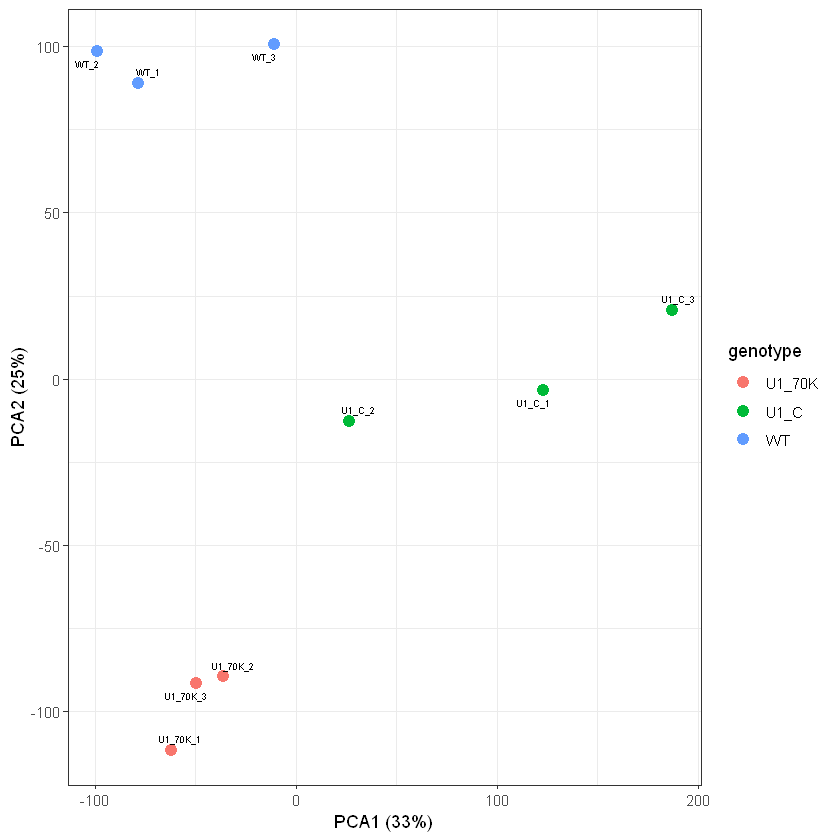

In [27]:
#PCA for PC1 and PC2

pca1 <- ggplot(data=scores,aes(x = PC1, y = PC2, color = genotype)) +
  geom_point(size=3) +
  theme_bw() +
  geom_text_repel(aes(label=label),size=2,color="black")+
  labs(x = paste0("PCA1 (",round(summary$importance[2,1]*100),"%)"),
       y = paste0("PCA2 (",round(summary$importance[2,2]*100),"%)")) 

pca1

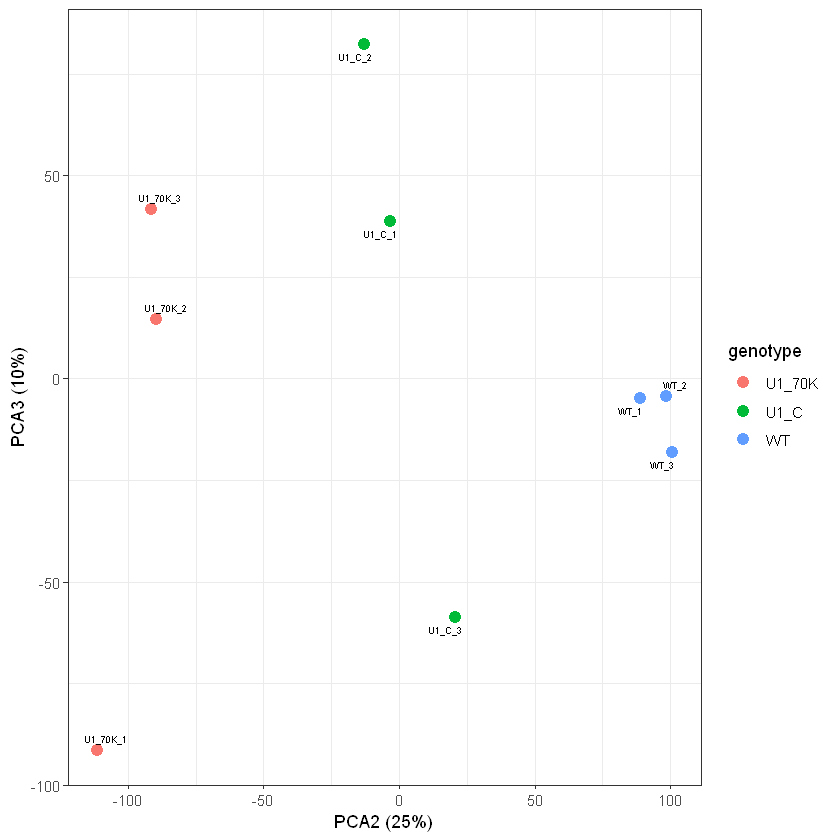

In [28]:
#PCA for PC2 and PC3

pca2 <- ggplot(data=scores,aes(x = PC2, y = PC3, color = genotype)) +
  geom_point(size=3) +
  theme_bw() +
  geom_text_repel(aes(label=label),size=2,color="black") +
  labs(x = paste0("PCA2 (",round(summary$importance[2,2]*100),"%)"),
       y = paste0("PCA3 (",round(summary$importance[2,3]*100),"%)")) 

pca2

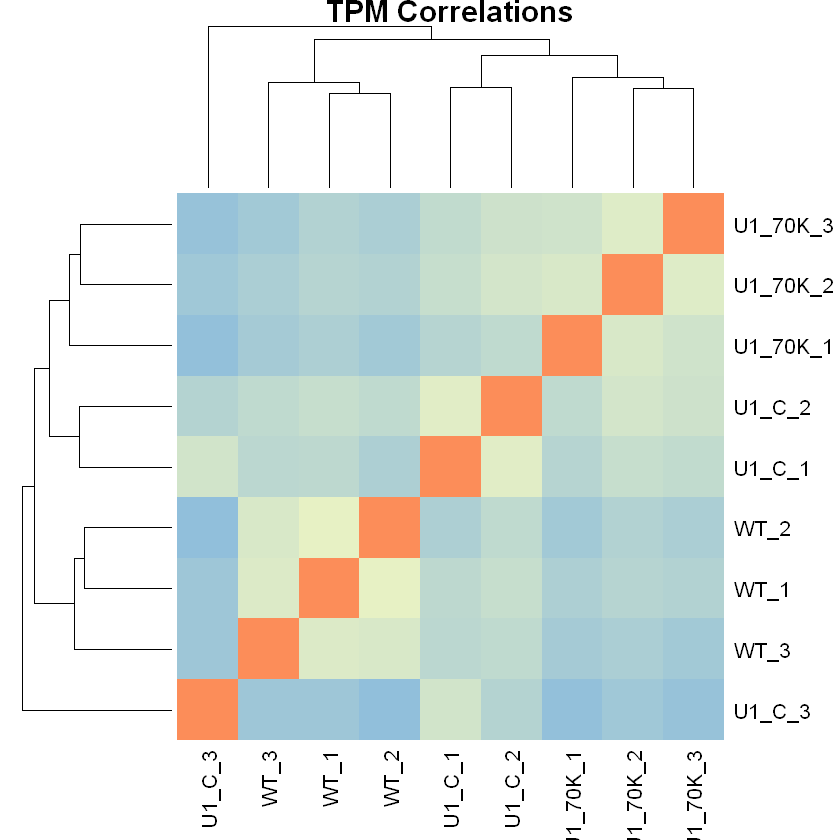

In [29]:
df              = txi$abundance
cor_matrix      = cor(df, method = "spearman")
dend            = as.dendrogram(hclust(dist(cor_matrix)))

corr_heatmap    = heatmap(cor_matrix, Rowv = dend, Colv = dend, col = colorRampPalette(c("#91BFDB", "#FFFFBF", "#FC8D59"))(100), scale = "none", main="TPM Correlations")

Based on the the correlation heatmap, we decided to leave out U1_C_rep3.
Next create the DESeq object using imported quantification, samplesheet and the list that connects transcript and gene (https://ics.hutton.ac.uk/atRTD/RTD3/AtRTD3_gene_transcript.csv)

In [ ]:
dds             = DESeqDataSetFromTximport(txi, samples, design = ~condition)
dds$condition   = factor(dds$condition, levels = c("WT","U1_C", "U1_70K"))
dds$condition   = relevel(dds$condition, ref = "WT")
dds             = dds[,-6]

Now filter all genes, that have 10 or less counts over all samples and perform deseq analysis

In [ ]:
keep    = rowSums(counts(dds)) >= 10
dds     = dds[keep,]
dds     = DESeq(dds)

Check the Dispersion Estimate to judge the quality

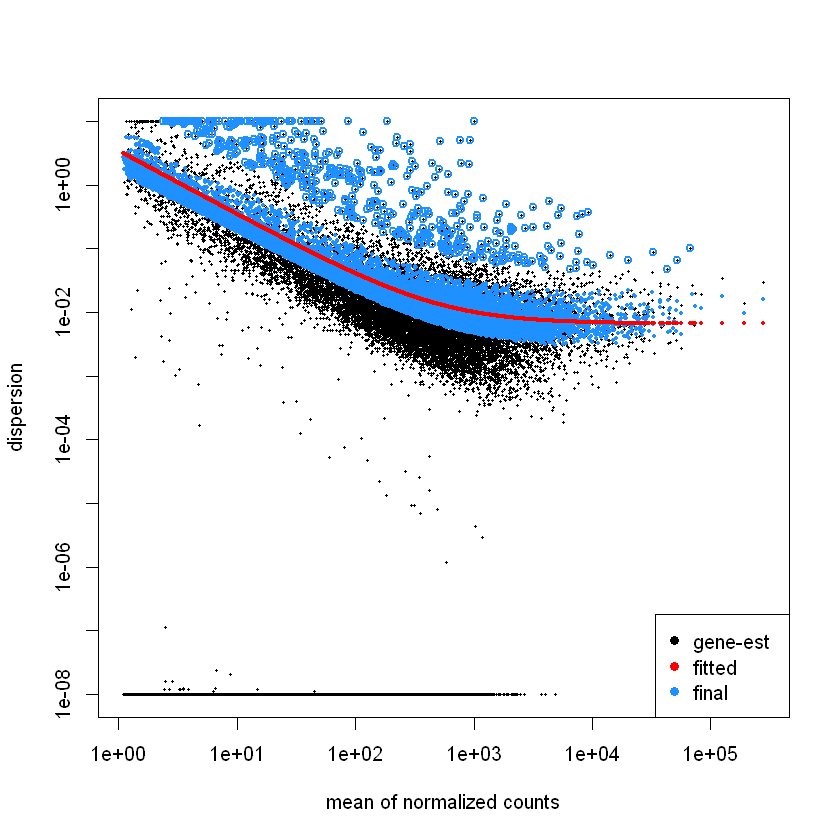

In [32]:
plotDispEsts(dds)

Extract results, check for overlaps and write the lists to csv

In [33]:
res_u1c         = results(dds, name = "condition_U1_C_vs_WT")
res_u170k       = results(dds, name = "condition_U1_70K_vs_WT")

#first single genotypes

up_u1c          = res_u1c   %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange > 0)
up_u170k        = res_u170k %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange > 0)
overlap_up      = intersect(rownames(up_u1c), rownames(up_u170k))

down_u1c        = res_u1c   %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange < 0)
down_u170k      = res_u170k %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange < 0)
overlap_down    = intersect(rownames(down_u1c), rownames(down_u170k))

write.csv(as.data.frame(res_u170k), file = "results_u170k_vs_wt.csv")
write.csv(as.data.frame(res_u1c),   file = "results_u1c_vs_wt.csv")


#now overlap

merged_up       = up_u1c %>% select(baseMean)
merged_up       = transform(merge(merged_up, up_u170k[,-1], by = 0), row.names = Row.names, Row.names=NULL)
merged_up       = transform(merge(merged_up, up_u1c[,-1],   by = 0, suffixes = c("_amiR-u1-70k", "_amirR-u1-c")), row.names = Row.names, Row.names=NULL)

merged_down     = down_u1c %>% select(baseMean)
merged_down     = transform(merge(merged_down, down_u170k[,-1], by = 0), row.names = Row.names, Row.names=NULL)
merged_down     = transform(merge(merged_down, down_u1c[,-1],   by = 0, suffixes = c("_amiR-u1-70k", "_amirR-u1-c")), row.names = Row.names, Row.names=NULL)


write.csv(merged_up,    file = "overlap_upregulated_u170k_u1c.csv")
write.csv(merged_down,  file = "overlap_downregulated_u170k_u1c.csv")

2. Do the rmats/splicing analysis

load all files

In [36]:
#first read in all tables
u1c_se      = read.table("results/rmats/U1C/WT_vs_U1C/SE.MATS.JC.txt",          header = T)
u1c_ri      = read.table("results/rmats/U1C/WT_vs_U1C/RI.MATS.JC.txt",          header = T)
u1c_a5s     = read.table("results/rmats/U1C/WT_vs_U1C/A5SS.MATS.JC.txt",        header = T)
u1c_a3s     = read.table("results/rmats/U1C/WT_vs_U1C/A3SS.MATS.JC.txt",        header = T)
u1c_mxe     = read.table("results/rmats/U1C/WT_vs_U1C/MXE.MATS.JC.txt",         header = T)



u170k_se    = read.table("results/rmats/U170K/WT_vs_U170K/SE.MATS.JC.txt",      header = T)
u170k_ri    = read.table("results/rmats/U170K/WT_vs_U170K/RI.MATS.JC.txt",      header = T)
u170k_a5s   = read.table("results/rmats/U170K/WT_vs_U170K/A5SS.MATS.JC.txt",    header = T)
u170k_a3s   = read.table("results/rmats/U170K/WT_vs_U170K/A3SS.MATS.JC.txt",    header = T)
u170k_mxe   = read.table("results/rmats/U170K/WT_vs_U170K/MXE.MATS.JC.txt",     header = T)

In [38]:
#define criteria to find same events and find overlaps between groups

overlap_se = merge(u1c_se %>% filter(FDR < 0.05) %>% 
      select(GeneID, exonStart_0base, exonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_se %>% filter(FDR < 0.05) %>% select(GeneID, exonStart_0base, exonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_ri = merge(u1c_ri %>% filter(FDR < 0.05) %>% 
      select(GeneID, riExonStart_0base , riExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_ri %>% filter(FDR < 0.05) %>% select(GeneID, riExonStart_0base, riExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_a5s = merge(u1c_a5s %>% filter(FDR < 0.05) %>% 
      select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      u170k_a5s %>% filter(FDR < 0.05) %>% select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_a3s = merge(u1c_a3s %>% filter(FDR < 0.05) %>%
      select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE ,FDR, IncLevelDifference),
      u170k_a3s %>% filter(FDR < 0.05) %>% select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_mxe = merge(u1c_mxe %>% filter(FDR < 0.05) %>%
      select(GeneID, X1stExonStart_0base, X1stExonEnd, X2ndExonStart_0base, X2ndExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_mxe %>% filter(FDR < 0.05) %>% select(GeneID, X1stExonStart_0base, X1stExonEnd, X2ndExonStart_0base, X2ndExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:9), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

In [39]:
#get just the numbers
numbers_u1c     = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), amount = c(1:5),     amount_up = c(1:5),     amount_down = c(1:5))
numbers_u170k   = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), amount = c(1:5),     amount_up = c(1:5),     amount_down = c(1:5))
numbers_overlap = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), overlap = c(1:5),    overlap_up = c(1:5),    overlap_down = c(1:5), ambi = c(1:5))

In [40]:
#filter by enhanced and repressed
numbers_u170k[1,2] = u170k_a3s  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[1,3] = u170k_a3s  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[1,4] = u170k_a3s  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[2,2] = u170k_a5s  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[2,3] = u170k_a5s  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[2,4] = u170k_a5s  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[3,2] = u170k_mxe  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[3,3] = u170k_mxe  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[3,4] = u170k_mxe  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[4,2] = u170k_ri   %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[4,3] = u170k_ri   %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[4,4] = u170k_ri   %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[5,2] = u170k_se   %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[5,3] = u170k_se   %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[5,4] = u170k_se   %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow





numbers_u1c[1,2] = u1c_a3s      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[1,3] = u1c_a3s      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[1,4] = u1c_a3s      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[2,2] = u1c_a5s      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[2,3] = u1c_a5s      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[2,4] = u1c_a5s      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[3,2] = u1c_mxe      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[3,3] = u1c_mxe      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[3,4] = u1c_mxe      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[4,2] = u1c_ri       %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[4,3] = u1c_ri       %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[4,4] = u1c_ri       %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[5,2] = u1c_se       %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[5,3] = u1c_se       %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[5,4] = u1c_se       %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow


In [41]:
#get overlap numbers
numbers_overlap[1,2] = overlap_a3s %>% nrow
numbers_overlap[1,3] = overlap_a3s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[1,4] = overlap_a3s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[1,5] = overlap_a3s %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[2,2] = overlap_a5s %>% nrow
numbers_overlap[2,3] = overlap_a5s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[2,4] = overlap_a5s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[2,5] = overlap_a5s %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[3,2] = overlap_mxe %>% nrow
numbers_overlap[3,3] = overlap_mxe %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[3,4] = overlap_mxe %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[3,5] = overlap_mxe %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[4,2] = overlap_ri %>% nrow
numbers_overlap[4,3] = overlap_ri %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[4,4] = overlap_ri %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[4,5] = overlap_ri %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow

numbers_overlap[5,2] = overlap_se %>% nrow
numbers_overlap[5,3] = overlap_se %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` >= 0) %>% nrow
numbers_overlap[5,4] = overlap_se %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` <= 0 & `IncLevelDifference_amirR-u1-70k` <= 0) %>% nrow
numbers_overlap[5,5] = overlap_se %>% filter((`IncLevelDifference_amiR-u1-c`<= 0 & `IncLevelDifference_amirR-u1-70k`>= 0) | (`IncLevelDifference_amiR-u1-c` >= 0 & `IncLevelDifference_amirR-u1-70k` <= 0)) %>% nrow


In [42]:
#write output data
write.csv(overlap_a3s,  "overlap_A3SS.csv")
write.csv(overlap_a5s,  "overlap_A5SS.csv")
write.csv(overlap_mxe,  "overlap_MXE.csv")
write.csv(overlap_ri,   "overlap_RI.csv")
write.csv(overlap_se,   "overlap_SE.csv")

summary = merge(merge(numbers_u1c, numbers_u170k, by = "event", suffixes = c("_u1c", "_u170k")), numbers_overlap, by = 1)

write.csv(summary, "summary.csv")

3. Analysis for revision

3.1 Make bed files to search for denovo and known motifs around the pA sites and unrelated introns at the same relative position as the polyA-Sites

3.2 check for nucleotide frequency around the pA-sites and unrelated introns at the same relative position as the polyA-Sites


3.3 check for overlaps between DEGs and splicing events

3.4 Check for expression changes of genes encoding mRNA cleavage and polyadenylation factors

3.5 Check for splicing changes of genes enconding mRNA cleavage and polyadenlyation factors

In [ ]:
--bed_prox_rep_pA_composite_u170k   'bedfiles/proximal_pA_comp_rep_u170k.bed' 
--bed_prox_rep_pA_composite_u1c     'bedfiles/proximal_pA_comp_rep_u1c.bed' 
--bed_background_rnd_intron         'bedfiles/bed_position_at_onethird_of_all_introns.bed' 
--bed_background_distal_pAs         'bedfiles/distal_sites_u170k_above_005.bed'



In [10]:
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22621)

Matrix products: default

locale:
[1] LC_COLLATE=English_Germany.utf8  LC_CTYPE=English_Germany.utf8   
[3] LC_MONETARY=English_Germany.utf8 LC_NUMERIC=C                    
[5] LC_TIME=English_Germany.utf8    

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] dplyr_1.1.2                 ggrepel_0.9.3              
 [3] ggplot2_3.4.2               DESeq2_1.38.3              
 [5] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [7] MatrixGenerics_1.10.0       matrixStats_1.0.0          
 [9] GenomicRanges_1.50.2        GenomeInfoDb_1.34.9        
[11] IRanges_2.32.0              S4Vectors_0.36.2           
[13] BiocGenerics_0.44.0         tximport_1.26.1            

loaded via a namespace (and not attached):
 [1] locfit_1.5-9.8         Rcpp_1.0.10            lattice